<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/GAN/WGAN_Cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN (Wasserstein GAN)



# Import and Config

In [1]:
!pip install -q --upgrade albumentations==0.5.1

     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 36.7MB 86kB/s 
     |████████████████████████████████| 952kB 56.6MB/s 


In [2]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [3]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# Define Model

In [16]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class Reshape(nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x

class Generator(nn.Module):
    def __init__(self, class_num=10, dim=64, in_height=IN_HEIGHT, in_width=IN_WIDTH, in_channel=3):
        super(Generator, self).__init__()

        self.module = nn.Sequential(
            nn.Linear(100, (in_height // 16) * (in_width // 16) * dim * 8, bias=False),
            Reshape(dim * 8, in_height // 16, in_width // 16),
            nn.BatchNorm2d(dim * 8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim * 8, dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim * 4),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim * 4, dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim * 2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim * 2, dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim, in_channel, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.module(x)


class Discriminator(torch.nn.Module):
    def __init__(self, class_num=10, dim=64, in_height=IN_HEIGHT, in_width=IN_WIDTH, in_channel=3):
        super(Discriminator, self).__init__()

        self.module = nn.Sequential(
            nn.Conv2d(in_channel, dim, kernel_size=4, padding=1, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(dim, dim * 2, kernel_size=4, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(dim * 2),
            nn.LeakyReLU(),
            nn.Conv2d(dim * 2, dim * 4, kernel_size=4, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(dim * 4),
            nn.LeakyReLU(),
            nn.Conv2d(dim * 4, 1, kernel_size=[in_height // 8, in_width // 8], padding=0, stride=1),
            Flatten(),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.module(x)


# Dataset

In [17]:
class Cifar10Dataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx] / 127.5 - 1
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

In [18]:
transforms_train = A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.ShiftScaleRotate(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [19]:
def show_sample(Xs, show_num=10, name="input"):
    Xs = Xs.detach().cpu().numpy().transpose(0, 2, 3, 1)
    Xs = (Xs * 127.5 + 127.5).astype(np.uint8)

    plt.figure(figsize=(12, 1))

    for i in range(show_num):
        # show input
        x = Xs[i]
        plt.subplot(1, show_num, i + 1)
        plt.imshow(x, cmap="gray")
        plt.title(name)
        plt.axis('off')
        
    plt.show()


In [24]:
def train():
    train_models = []
    train_model_paths = []

    EPOCH = 50
        
    train_losses_d = []
    train_losses_g = []
        
    #---
    # datasert
    #---
    batch_size = 256

    train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
    train_Xs = train_ds.data.astype(np.float32)
    train_ys = np.array(train_ds.targets)

    dataset_train = Cifar10Dataset(train_Xs, train_ys, transforms=transforms_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=4, shuffle=True, pin_memory=True)

    train_n = len(dataloader_train)

    #---
    # model
    #---
    gen = Generator().to(device)
    dis = Discriminator().to(device)

    criterion = nn.BCELoss()

    opt_d = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.9))
    opt_g = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.9))

    # opt_d = torch.optim.RMSprop(dis.parameters(), lr=0.0005)
    # opt_g = torch.optim.RMSprop(gen.parameters(), lr=0.0005)

    #---
    # WGAN hyper params
    #---
    Clip_value = 0.01
    Critic_time = 5

    #---
    # epoch
    #---
    for epoch in range(EPOCH):
        gen.train()
        dis.train()
        
        tr_loss_d = 0
        tr_loss_g = 0
        total = 0
        
        #---
        # train
        #---
        train_time_start = time.time()
        
        for step, batch in enumerate(dataloader_train):
            opt_g.zero_grad()

            xs = batch[0].to(device)
            ys = batch[1]

            _batch_size = len(xs)

            ones = torch.ones([_batch_size, 1]).to(device)
            zeros = torch.zeros([_batch_size, 1]).to(device)

            #---
            # update discriminator
            #---

            for c_time in range(Critic_time):
                opt_d.zero_grad()

                # real x
                y_real = dis(xs)
                loss_real = torch.mean(y_real)

                # fake x
                zs = np.random.uniform(-1, 1, size=(_batch_size, 100))
                zs = torch.tensor(zs, dtype=torch.float).to(device)
                x_fake = gen(zs)
                y_fake = dis(x_fake)
                loss_fake = torch.mean(y_fake)
                loss_d = loss_real - loss_fake
                loss_d.backward()
                opt_d.step()

                tr_loss_d += loss_d.item() / train_n / Critic_time

                # parameter clipping > [-clip_value, clip_value]
                for param in dis.parameters():
                    param.data.clamp_(- Clip_value, Clip_value)

            #---
            # update generator
            #--- 
            opt_d.zero_grad()
            opt_g.zero_grad()

            zs = np.random.uniform(-1, 1, size=(_batch_size, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)
            x_fake = gen(zs)
            y_fake = dis(x_fake)
            loss_g = y_fake.mean(0).view(1)
            loss_g.backward()
            opt_g.step()

            tr_loss_g += loss_g.item() / train_n

        train_losses_d.append(tr_loss_d)
        train_losses_g.append(tr_loss_g)

        train_time_end = time.time()

        train_time_total = train_time_end - train_time_start
            
        print(f"epoch:{epoch + 1}/{EPOCH} [tra]loss-d:{tr_loss_d:.4f} loss-g:{tr_loss_g:.4f} [time]tra:{train_time_total:.2f}sec")

        if (epoch + 1) % 100 == 0:
            savename = f"model_epoch{epoch + 1}_{EPOCH}.pth"
            torch.save(gen.state_dict(), savename)
            print(f"model saved to >> {savename}")

        if (epoch + 1) % 10 == 0:
            show_sample(x_fake, name="output")

    #---
    # save model
    #---
    savename = f"model_epoch{EPOCH}.pth"
    torch.save(gen.state_dict(), savename)
    print(f"model saved to >> {savename}")
    print()
    
    train_models.append(gen)
    train_model_paths.append(savename)
    

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.grid()
    ax1.plot(train_losses_d, marker=".", markersize=6, color="red", label="train loss d")
    ax1.plot(train_losses_g, marker=".", markersize=6, color="blue", label="train loss g")
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc="upper right")
    ax1.set(xlabel="Epoch", ylabel="Loss")
    plt.show()

        
    return train_models, train_model_paths


Files already downloaded and verified
epoch:1/50 [tra]loss-d:-0.1446 loss-g:0.5757 [time]tra:44.98sec
epoch:2/50 [tra]loss-d:-0.1331 loss-g:0.5707 [time]tra:44.92sec
epoch:3/50 [tra]loss-d:-0.1120 loss-g:0.5613 [time]tra:44.98sec
epoch:4/50 [tra]loss-d:-0.0977 loss-g:0.5555 [time]tra:44.94sec
epoch:5/50 [tra]loss-d:-0.0874 loss-g:0.5503 [time]tra:44.93sec
epoch:6/50 [tra]loss-d:-0.0806 loss-g:0.5473 [time]tra:44.91sec
epoch:7/50 [tra]loss-d:-0.0756 loss-g:0.5451 [time]tra:44.93sec
epoch:8/50 [tra]loss-d:-0.0722 loss-g:0.5444 [time]tra:44.92sec
epoch:9/50 [tra]loss-d:-0.0687 loss-g:0.5425 [time]tra:44.91sec
epoch:10/50 [tra]loss-d:-0.0660 loss-g:0.5420 [time]tra:44.98sec


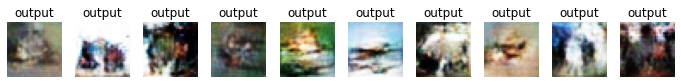

epoch:11/50 [tra]loss-d:-0.0644 loss-g:0.5408 [time]tra:45.04sec
epoch:12/50 [tra]loss-d:-0.0621 loss-g:0.5399 [time]tra:44.97sec
epoch:13/50 [tra]loss-d:-0.0595 loss-g:0.5380 [time]tra:44.89sec
epoch:14/50 [tra]loss-d:-0.0579 loss-g:0.5367 [time]tra:44.93sec
epoch:15/50 [tra]loss-d:-0.0567 loss-g:0.5368 [time]tra:44.90sec
epoch:16/50 [tra]loss-d:-0.0553 loss-g:0.5360 [time]tra:44.93sec
epoch:17/50 [tra]loss-d:-0.0545 loss-g:0.5353 [time]tra:44.96sec
epoch:18/50 [tra]loss-d:-0.0532 loss-g:0.5340 [time]tra:44.93sec
epoch:19/50 [tra]loss-d:-0.0519 loss-g:0.5332 [time]tra:44.98sec
epoch:20/50 [tra]loss-d:-0.0507 loss-g:0.5331 [time]tra:44.99sec


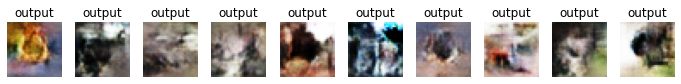

epoch:21/50 [tra]loss-d:-0.0497 loss-g:0.5316 [time]tra:44.94sec
epoch:22/50 [tra]loss-d:-0.0483 loss-g:0.5306 [time]tra:44.99sec
epoch:23/50 [tra]loss-d:-0.0473 loss-g:0.5293 [time]tra:44.95sec
epoch:24/50 [tra]loss-d:-0.0466 loss-g:0.5306 [time]tra:44.97sec
epoch:25/50 [tra]loss-d:-0.0455 loss-g:0.5284 [time]tra:44.93sec
epoch:26/50 [tra]loss-d:-0.0451 loss-g:0.5299 [time]tra:44.92sec
epoch:27/50 [tra]loss-d:-0.0444 loss-g:0.5283 [time]tra:44.93sec
epoch:28/50 [tra]loss-d:-0.0437 loss-g:0.5287 [time]tra:44.95sec
epoch:29/50 [tra]loss-d:-0.0429 loss-g:0.5279 [time]tra:44.95sec
epoch:30/50 [tra]loss-d:-0.0422 loss-g:0.5271 [time]tra:44.91sec


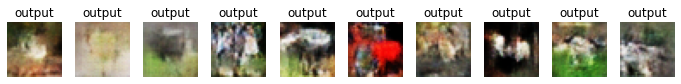

epoch:31/50 [tra]loss-d:-0.0417 loss-g:0.5287 [time]tra:45.05sec
epoch:32/50 [tra]loss-d:-0.0414 loss-g:0.5285 [time]tra:45.03sec
epoch:33/50 [tra]loss-d:-0.0409 loss-g:0.5273 [time]tra:45.08sec
epoch:34/50 [tra]loss-d:-0.0410 loss-g:0.5277 [time]tra:45.08sec
epoch:35/50 [tra]loss-d:-0.0396 loss-g:0.5248 [time]tra:45.07sec
epoch:36/50 [tra]loss-d:-0.0396 loss-g:0.5262 [time]tra:44.94sec
epoch:37/50 [tra]loss-d:-0.0393 loss-g:0.5252 [time]tra:45.02sec
epoch:38/50 [tra]loss-d:-0.0383 loss-g:0.5252 [time]tra:44.99sec
epoch:39/50 [tra]loss-d:-0.0380 loss-g:0.5242 [time]tra:44.94sec
epoch:40/50 [tra]loss-d:-0.0377 loss-g:0.5246 [time]tra:44.92sec


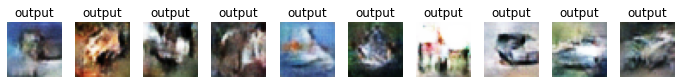

epoch:41/50 [tra]loss-d:-0.0369 loss-g:0.5236 [time]tra:45.00sec
epoch:42/50 [tra]loss-d:-0.0364 loss-g:0.5228 [time]tra:44.95sec
epoch:43/50 [tra]loss-d:-0.0362 loss-g:0.5238 [time]tra:44.94sec
epoch:44/50 [tra]loss-d:-0.0358 loss-g:0.5227 [time]tra:44.91sec
epoch:45/50 [tra]loss-d:-0.0353 loss-g:0.5231 [time]tra:44.96sec
epoch:46/50 [tra]loss-d:-0.0351 loss-g:0.5224 [time]tra:44.96sec
epoch:47/50 [tra]loss-d:-0.0343 loss-g:0.5216 [time]tra:44.95sec
epoch:48/50 [tra]loss-d:-0.0340 loss-g:0.5223 [time]tra:44.93sec
epoch:49/50 [tra]loss-d:-0.0335 loss-g:0.5214 [time]tra:44.95sec
epoch:50/50 [tra]loss-d:-0.0335 loss-g:0.5232 [time]tra:44.90sec


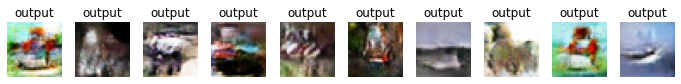

model saved to >> model_epoch50.pth



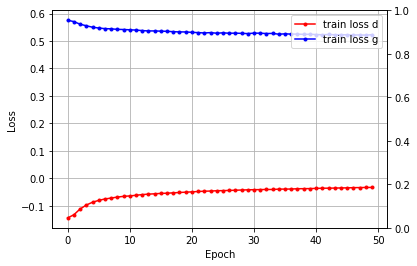

In [25]:
train_models, train_model_paths = train()

# Test

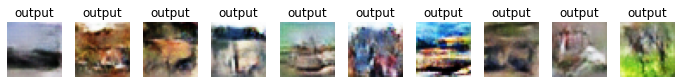

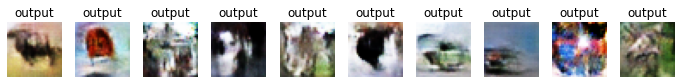

In [26]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    with torch.no_grad():
        model = train_models[0]

        for _ in range(2):
            zs = np.random.uniform(-1, 1, size=(10, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)

            xs = model(zs)
            show_sample(xs, name="output")

test(train_models)